In [2]:
import random
import jieba
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

###  Map Search with BFS

In [3]:
# naming
BEIJING, CHANGCHUN, MULUMUQI, WUHAN, GUNAGHZOU, SHENZHEN, BANGKOK, SHANGHAI, NEWYORK = """
BEIJING CHANGCHUN MULUMUQI WUHAN GUANGZHOU SHENZHEN BANGKOK SHANGHAI NEWYORK
""".split()

In [4]:
# build up connections
connection = {
    CHANGCHUN: [BEIJING],
    MULUMUQI: [BEIJING], 
    BEIJING: [MULUMUQI, CHANGCHUN, WUHAN, SHENZHEN, NEWYORK],
    NEWYORK: [BEIJING, SHANGHAI],
    SHANGHAI: [NEWYORK, WUHAN],
    WUHAN: [SHANGHAI, BEIJING, GUNAGHZOU],
    GUNAGHZOU: [WUHAN, BANGKOK],
    SHENZHEN: [WUHAN, BANGKOK],
    BANGKOK: [SHENZHEN, GUNAGHZOU]
}

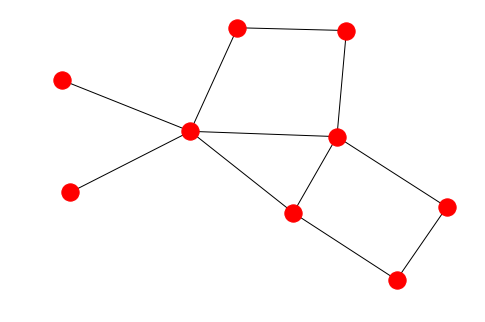

In [5]:
# visualize
graph = nx.Graph(connection)
nx.draw(graph)

In [6]:
def nagivator_bfs(start, destination, connection_graph):
    pathes = [start ]
    seen = set()
    
    while pathes:
        froniter = pathes.pop(0)
        if froniter in seen: continue
            
        successors = connection_graph[froniter]
        print('standing on {} Looking forward {}'.format(froniter, successors))
        pathes = pathes + successors   
        seen.add(froniter)
        for s in successors:
            if s == destination: 
                return seen

In [7]:
nagivator_bfs(BEIJING, SHANGHAI, connection)

standing on BEIJING Looking forward ['MULUMUQI', 'CHANGCHUN', 'WUHAN', 'SHENZHEN', 'NEWYORK']
standing on MULUMUQI Looking forward ['BEIJING']
standing on CHANGCHUN Looking forward ['BEIJING']
standing on WUHAN Looking forward ['SHANGHAI', 'BEIJING', 'GUANGZHOU']


{'BEIJING', 'CHANGCHUN', 'MULUMUQI', 'WUHAN'}

### Sentence Generation 

In [8]:
grammar = """
sentence => noun_phrase verb_phrase 
noun_phrase => Article Adj* noun
Adj* => null | Adj Adj*
verb_phrase => verb noun_phrase
Article =>  一个 | 这个
noun =>   女人 |  篮球 | 桌子 | 小猫
verb => 看着   |  坐在 |  听着 | 看见
Adj =>   蓝色的 |  好看的 | 小小的
"""

In [9]:
def parse_grammar(grammar_str, sep='=>'):
    grammar = {}
    for line in grammar_str.split('\n'): 
        line = line.strip()
        if not line: continue
        
        target, rules = line.split(sep)
        
        grammar[target.strip()] = [r.split() for r in rules.split('|')]
    
    return grammar

In [10]:
def gene(grammar_parsed, target='sentence'):
    if target not in grammar_parsed: return target
    
    rule = random.choice(grammar_parsed[target])
    return ''.join(gene(grammar_parsed, target=r) for r in rule if r!='null')

In [11]:
gene(parse_grammar(grammar))

'这个小小的小猫听着一个小小的蓝色的小小的桌子'

### Pattern Matching 

#### Single Input 

In [12]:
def is_variable(pat):
    return pat.startswith('?') and all(s.isalpha() for s in pat[1:])

In [13]:
def pat_match(pattern, saying):
    if not pattern or not saying: return []
    
    if is_variable(pattern[0]):
        return [(pattern[0], saying[0])] + pat_match(pattern[1:], saying[1:])
    else:
        if pattern[0] != saying[0]: return []
        else:
            return pat_match(pattern[1:], saying[1:])

In [14]:
pat_match("?X greater than ?Y".split(), "3 greater than 2".split())

[('?X', '3'), ('?Y', '2')]

In [15]:
def pat_to_dict(patterns):
    return {k: v for k, v in patterns}

In [16]:
def subsitite(rule, parsed_rules):
    if not rule: return []
    
    return [parsed_rules.get(rule[0], rule[0])] + subsitite(rule[1:], parsed_rules)

In [17]:
pattern = pat_match('?P needs ?X'.split(), "John needs resting".split())
pattern

[('?P', 'John'), ('?X', 'resting')]

In [18]:
' '.join(subsitite("Why does ?P need ?X ?".split(), pat_to_dict(pattern)))

'Why does John need resting ?'

In [19]:
defined_patterns = {
    "I need ?X": ["Image you will get ?X soon", "Why do you need ?X ?"], 
    "My ?X told me something": ["Talk about more about your ?X", "How do you think about your ?X ?"]
}

In [21]:
def get_response(saying, rules):
    """" please implement the code, to get the response as followings:
    
    >>> get_response('I need iPhone') 
    >>> Image you will get iPhone soon
    >>> get_response("My mother told me something")
    >>> Talk about more about your monther.
    """
    for pattern, responses_list in rules.items():
        matched_pattern = pat_match(pattern.split(), saying.split())
        if matched_pattern:
            response_pattern = responses_list[random.randint(0,len(responses_list)-1)]
            return ' '.join(subsitite(response_pattern.split(), pat_to_dict(matched_pattern)))
    return "Sorry I don't understand"

In [22]:
get_response("My mother told me something", defined_patterns)

'Talk about more about your mother'

#### Sentence Input 

In [23]:
def is_pattern_segment(pattern):
    return pattern.startswith('?*') and all(a.isalpha() for a in pattern[2:])

In [24]:
is_pattern_segment('?*P')

True

In [25]:
fail = None

def pat_match_with_seg(pattern, saying):
    if not pattern or not saying: return []
    
    pat = pattern[0]
    
    if is_variable(pat):
        return [(pat, saying[0])] + pat_match_with_seg(pattern[1:], saying[1:])
    elif is_pattern_segment(pat):
        if segment_match(pattern, saying):
            match, index = segment_match(pattern, saying)
            return [match] + pat_match_with_seg(pattern[1:], saying[index:])
        else:
            return fail
    elif pat == saying[0]:
        return pat_match_with_seg(pattern[1:], saying[1:])
    else:
        return fail

In [26]:
def segment_match(pattern, saying):
    seg_pat, rest = pattern[0], pattern[1:]
    seg_pat = seg_pat.replace('?*', '?')

    if not rest: return (seg_pat, saying), len(saying)    
    
    for i, token in enumerate(saying):
        if rest[0] == token and is_match(rest[1:], saying[(i + 1):]):
            return (seg_pat, saying[:i]), i
    
    return None

def is_match(rest, saying):
    if not rest and not saying:
        return True
    if not all(a.isalpha() for a in rest[0]):
        return True
    if rest[0] != saying[0]:
        return False
    return is_match(rest[1:], saying[1:])

In [27]:
pat_match_with_seg('?*P is very good and ?*X'.split(), "My dog is very cute".split())

In [28]:
pat_match_with_seg('?*P is very good and ?*X'.split(), "My dog is very good and my cat is very cute".split())

[('?P', ['My', 'dog']), ('?X', ['my', 'cat', 'is', 'very', 'cute'])]

In [29]:
rule_responses = {
    '?*x hello ?*y': ['How do you do', 'Please state your problem'],
    '?*x I want ?*y': ['what would it mean if you got ?y', 'Why do you want ?y', 'Suppose you got ?y soon'],
    '?*x if ?*y': ['Do you really think its likely that ?y', 'Do you wish that ?y', 'What do you think about ?y', 'Really-- if ?y'],
    '?*x no ?*y': ['why not?', 'You are being a negative', 'Are you saying \'No\' just to be negative?'],
    '?*x I was ?*y': ['Were you really', 'Perhaps I already knew you were ?y', 'Why do you tell me you were ?y now?'],
    '?*x I feel ?*y': ['Do you often feel ?y ?', 'What other feelings do you have?']}

In [30]:
def pat_to_dict(patterns):
    return {k: ' '.join(v) if isinstance(v, list) else v for k, v in patterns}

In [31]:
def get_response_sentence(saying, rules):

    for pattern, responses_list in rules.items():
        matched_pattern_list = pat_match_with_seg(pattern.split(), saying.split())
        if matched_pattern_list:
            response_pattern = responses_list[random.randint(0,len(responses_list)-1)]
            response_dict = pat_to_dict(matched_pattern_list)
            words = subsitite(response_pattern.split(), response_dict)
            return ' '.join(words)
    return None

In [32]:
get_response_sentence('I feel I can not lose you', rule_responses)

'Do you often feel I can not lose you ?'

### Reflections - 问题3

In [33]:
reflections = {
    "i"        : "you",
  "i am"       : "you are",
  "i was"      : "you were",
  "i"          : "you",
  "i'm"        : "you are",
  "i'd"        : "you would",
  "i've"       : "you have",
  "i'll"       : "you will",
  "my"         : "your",
  "you are"    : "I am",
  "you were"   : "I was",
  "you've"     : "I have",
  "you'll"     : "I will",
  "your"       : "my",
  "yours"      : "mine",
  "you"        : "me",
  "me"         : "you"
}

In [34]:
def subsitite(rule, parsed_rules):
    if not rule: return []
    
    return [parsed_rules.get(rule[0], rule[0])] + subsitite(rule[1:], parsed_rules)

In [174]:
def get_response_sentence(saying, rules, reflect_flag = True, language = 'eng'):
    
    # delect language
    if is_chinese(saying):
        language = 'chinese'
    else:
        language = 'english'
        
    for pattern, responses_list in rules.items():
        if language == 'english':
            matched_pattern_list = pat_match_with_seg(pattern.split(), saying.split())
        elif language == 'chinese':
            matched_pattern_list = pat_match_with_seg(pattern.split(), ' '.join(jieba.cut(saying)).split())
        else:
            print('Language can not be identified!')
            break
        
        if matched_pattern_list:
            
            # find patterns
            response_pattern = responses_list[random.randint(0,len(responses_list)-1)]
            # return dictionary
            response_dict = pat_to_dict(matched_pattern_list)
            
            # add reflections
            if reflect_flag:  
                response_dict = reflect(response_dict, reflections)
                
            # return sentences
            words = subsitite(response_pattern.split(), response_dict)
            print(words)
            return ' '.join(words)
    return None

In [175]:
def reflect(response_dict, reflections):
    for key, value in response_dict.items():
        words = value.split()
        response_dict[key] = ' '.join(str(reflections.get(word.lower(), word)) for word in words)
    return response_dict
                

In [176]:
get_response_sentence('I feel I can not lose you', rule_responses)

['What', 'other', 'feelings', 'do', 'you', 'have?']


'What other feelings do you have?'

### Chinese - 问题2

In [104]:
rule_responses = {
    '?*x hello ?*y': ['How do you do', 'Please state your problem'],
    '?*x I want ?*y': ['what would it mean if you got ?y', 'Why do you want ?y', 'Suppose you got ?y soon'],
    '?*x if ?*y': ['Do you really think its likely that ?y', 'Do you wish that ?y', 'What do you think about ?y', 'Really-- if ?y'],
    '?*x no ?*y': ['why not?', 'You are being a negative', 'Are you saying \'No\' just to be negative?'],
    '?*x I was ?*y': ['Were you really', 'Perhaps I already knew you were ?y', 'Why do you tell me you were ?y now?'],
    '?*x I feel ?*y': ['Do you often feel ?y ?', 'What other feelings do you have?'],
    '?*x你好?*y': ['你好呀', '请告诉我你的问题'],
    '?*x我想?*y': ['你觉得?y有什么意义呢？', '为什么你想?y', '你可以想想你很快就可以?y了'],
    '?*x我想要?*y': ['?x想问你，你觉得?y有什么意义呢?', '为什么你想?y', '?x觉得... 你可以想想你很快就可以有?y了', '你看?x像?y不', '我看你就像?y'],
    '?*x喜欢?*y': ['喜欢?y的哪里？', '?y有什么好的呢？', '你想要?y吗？'],
    '?*x讨厌?*y': ['?y怎么会那么讨厌呢?', '讨厌?y的哪里？', '?y有什么不好呢？', '你不想要?y吗？'],
    '?*xAI?*y': ['你为什么要提AI的事情？', '你为什么觉得AI要解决你的问题？'],
    '?*x机器人?*y': ['你为什么要提机器人的事情？', '你为什么觉得机器人要解决你的问题？'],
    '?*x对不起?*y': ['不用道歉', '你为什么觉得你需要道歉呢?'],
    '?*x我记得?*y': ['你经常会想起这个吗？', '除了?y你还会想起什么吗？', '你为什么和我提起?y'],
    '?*x如果?*y': ['你真的觉得?y会发生吗？', '你希望?y吗?', '真的吗？如果?y的话', '关于?y你怎么想？'],
    '?*x我?*z梦见?*y':['真的吗? --- ?y', '你在醒着的时候，以前想象过?y吗？', '你以前梦见过?y吗'],
    '?*x妈妈?*y': ['你家里除了?y还有谁?', '嗯嗯，多说一点和你家里有关系的', '她对你影响很大吗？'],
    '?*x爸爸?*y': ['你家里除了?y还有谁?', '嗯嗯，多说一点和你家里有关系的', '他对你影响很大吗？', '每当你想起你爸爸的时候， 你还会想起其他的吗?'],
    '?*x我愿意?*y': ['我可以帮你?y吗？', '你可以解释一下，为什么想?y'],
    '?*x我很难过，因为?*y': ['我听到你这么说， 也很难过', '?y不应该让你这么难过的'],
    '?*x难过?*y': ['我听到你这么说， 也很难过',
                 '不应该让你这么难过的，你觉得你拥有什么，就会不难过?',
                 '你觉得事情变成什么样，你就不难过了?'],
    '?*x就像?*y': ['你觉得?x和?y有什么相似性？', '?x和?y真的有关系吗？', '怎么说？'],
    '?*x和?*y都?*z': ['你觉得?z有什么问题吗?', '?z会对你有什么影响呢?'],
    '?*x和?*y一样?*z': ['你觉得?z有什么问题吗?', '?z会对你有什么影响呢?'],
    '?*x我是?*y': ['真的吗？', '?x想告诉你，或许我早就知道你是?y', '你为什么现在才告诉我你是?y'],
    '?*x我是?*y吗': ['如果你是?y会怎么样呢？', '你觉得你是?y吗', '如果你是?y，那一位着什么?'],
    '?*x你是?*y吗':  ['你为什么会对我是不是?y感兴趣?', '那你希望我是?y吗', '你要是喜欢， 我就会是?y'],
    '?*x你是?*y' : ['为什么你觉得我是?y'],
    '?*x因为?*y' : ['?y是真正的原因吗？', '你觉得会有其他原因吗?'],
    '?*x我不能?*y': ['你或许现在就能?*y', '如果你能?*y,会怎样呢？'],
    '?*x我觉得?*y': ['你经常这样感觉吗？', '除了到这个，你还有什么其他的感觉吗？'],
    '?*x我?*y你?*z': ['其实很有可能我们互相?y'],
    '?*x你为什么不?*y': ['你自己为什么不?y', '你觉得我不会?y', '等我心情好了，我就?y'],
    '?*x好的?*y': ['好的', '你是一个很正能量的人'],
    '?*x嗯嗯?*y': ['好的', '你是一个很正能量的人'],
    '?*x不嘛?*y': ['为什么不？', '你有一点负能量', '你说 不，是想表达不想的意思吗？'],
    '?*x不要?*y': ['为什么不？', '你有一点负能量', '你说 不，是想表达不想的意思吗？'],
    '?*x有些人?*y': ['具体是哪些人呢?'],
    '?*x有的人?*y': ['具体是哪些人呢?'],
    '?*x某些人?*y': ['具体是哪些人呢?'],
    '?*x每个人?*y': ['我确定不是人人都是', '你能想到一点特殊情况吗？', '例如谁？', '你看到的其实只是一小部分人'],
    '?*x所有人?*y': ['我确定不是人人都是', '你能想到一点特殊情况吗？', '例如谁？', '你看到的其实只是一小部分人'],
    '?*x总是?*y': ['你能想到一些其他情况吗?', '例如什么时候?', '你具体是说哪一次？', '真的---总是吗？'],
    '?*x一直?*y': ['你能想到一些其他情况吗?', '例如什么时候?', '你具体是说哪一次？', '真的---总是吗？'],
    '?*x或许?*y': ['你看起来不太确定'],
    '?*x可能?*y': ['你看起来不太确定'],
    '?*x他们是?*y吗？': ['你觉得他们可能不是?y？'],
    '?*x': ['很有趣', '请继续', '我不太确定我很理解你说的, 能稍微详细解释一下吗?']
}


In [162]:
def is_chinese(word):                                #判断句子中是否有中文出现
    for ch in word:
        if '\u4e00' <= ch <= '\u9fff':
            return True
    return False


def combine_variable(chinese_lst):
    new_lst = []
    temp = ''
    for word in chinese_lst:
        if is_chinese(word):
            if temp != "":
                new_lst.append(temp)
                temp = ""
            new_lst.append(word)
        else:
            temp = temp + word
    if temp != "": new_lst.append(temp)
    return new_lst

In [220]:
def get_response_sentence(saying, rules, reflect_flag = True):
    # delect language
    if is_chinese(saying):
        language = 'chinese'
    else:
        language = 'english'

    # iterate all possible response rules
    for pattern, responses_list in rules.items():
        if language == 'english':
            matched_pattern_list = pat_match_with_seg(pattern.split(), saying.split())
            if matched_pattern_list:
            
                # find patterns
                response_pattern = responses_list[random.randint(0,len(responses_list)-1)]
                # return dictionary
                response_dict = pat_to_dict(matched_pattern_list)
                # add reflections
                if reflect_flag:  
                    response_dict = reflect(response_dict, reflections)
                # return sentences
                words = subsitite(response_pattern.split(), response_dict)
                return ' '.join(words)
                    
                    
        elif language == 'chinese':
            
            # create dictionary with Jieba
            pattern_list = combine_variable(' '.join(jieba.cut(pattern)).split())
            saying_list =  combine_variable(' '.join(jieba.cut(saying)).split())
            matched_pattern_list = pat_match_with_seg(pattern_list, saying_list)
            
            if matched_pattern_list:
            
                # find patterns
                response_pattern = responses_list[random.randint(0,len(responses_list)-1)]
                # return dictionary
                response_dict = pat_to_dict(matched_pattern_list)
                # add reflections
                if reflect_flag:  
                    response_dict = reflect(response_dict, reflections)
                # return sentences
                words = subsitite(combine_variable(' '.join(jieba.cut(response_pattern)).split()), response_dict)
                return ''.join(words)
        
        
        else:
            return 'Language can not be identified!'

    return None

In [221]:
def chatbot_test(inputs, rule_responses):
    for i in range(len(inputs)):
        response = get_response_sentence(inputs[i], rule_responses, reflect_flag = True)
        print(response)
    return

In [224]:
inputs = ['I want you', 
          'I feel I can not lose you', 
          'I feel sick', 
          '我喜欢滑雪', 
          '有些人活着',  
          '但是他死了',]
chatbot_test(inputs, rule_responses)

Suppose you got me soon
What other feelings do you have?
Do you often feel sick ?
滑雪有什么好的呢？
具体是哪些人呢?
很有趣
